In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'elu',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

elu_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:11 - loss: 0.0899 - STD: 0.0423 - MAE: 0.2870

 5/64 [=>............................] - ETA: 0s - loss: 0.0799 - STD: 0.0085 - MAE: 0.2608  

 8/64 [==>...........................] - ETA: 0s - loss: 0.0786 - STD: 0.0053 - MAE: 0.2579

12/64 [====>.........................] - ETA: 0s - loss: 0.0781 - STD: 0.0035 - MAE: 0.2565

16/64 [======>.......................] - ETA: 0s - loss: 0.0781 - STD: 0.0026 - MAE: 0.2562

20/64 [========>.....................] - ETA: 0s - loss: 0.0781 - STD: 0.0021 - MAE: 0.2559

24/64 [==========>...................] - ETA: 0s - loss: 0.0780 - STD: 0.0018 - MAE: 0.2557

28/64 [============>.................] - ETA: 0s - loss: 0.0778 - STD: 0.0015 - MAE: 0.2554

31/64 [=============>................] - ETA: 0s - loss: 0.0778 - STD: 0.0014 - MAE: 0.2553

34/64 [==============>...............] - ETA: 0s - loss: 0.0777 - STD: 0.0012 - MAE: 0.2551

38/64 [================>.............] - ETA: 0s - loss: 0.0777 - STD: 0.0011 - MAE: 0.2550

42/64 [==================>...........] - ETA: 0s - loss: 0.0776 - STD: 0.0010 - MAE: 0.2549

46/64 [====================>.........] - ETA: 0s - loss: 0.0775 - STD: 9.1905e-04 - MAE: 0.2547

50/64 [======================>.......] - ETA: 0s - loss: 0.0775 - STD: 8.4553e-04 - MAE: 0.2547

54/64 [========================>.....] - ETA: 0s - loss: 0.0774 - STD: 7.8290e-04 - MAE: 0.2546

58/64 [==========================>...] - ETA: 0s - loss: 0.0774 - STD: 7.2891e-04 - MAE: 0.2545

62/64 [============================>.] - ETA: 0s - loss: 0.0774 - STD: 6.8188e-04 - MAE: 0.2545

64/64 [==============================] - 3s 33ms/step - loss: 0.0774 - STD: 6.6057e-04 - MAE: 0.2545 - val_loss: 0.0857 - val_STD: 1.0219e-14 - val_MAE: 0.2579


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0787 - STD: 1.0045e-14 - MAE: 0.2558

 5/64 [=>............................] - ETA: 0s - loss: 0.0776 - STD: 9.8732e-15 - MAE: 0.2544

 9/64 [===>..........................] - ETA: 0s - loss: 0.0775 - STD: 9.9170e-15 - MAE: 0.2543

13/64 [=====>........................] - ETA: 0s - loss: 0.0772 - STD: 9.9006e-15 - MAE: 0.2540

17/64 [======>.......................] - ETA: 0s - loss: 0.0773 - STD: 9.8754e-15 - MAE: 0.2541

21/64 [========>.....................] - ETA: 0s - loss: 0.0773 - STD: 9.8576e-15 - MAE: 0.2542

25/64 [==========>...................] - ETA: 0s - loss: 0.0774 - STD: 9.8584e-15 - MAE: 0.2542

29/64 [============>.................] - ETA: 0s - loss: 0.0774 - STD: 9.8288e-15 - MAE: 0.2542

33/64 [==============>...............] - ETA: 0s - loss: 0.0773 - STD: 9.8145e-15 - MAE: 0.2541

37/64 [================>.............] - ETA: 0s - loss: 0.0773 - STD: 9.8341e-15 - MAE: 0.2541

40/64 [=================>............] - ETA: 0s - loss: 0.0773 - STD: 9.8294e-15 - MAE: 0.2541

44/64 [===================>..........] - ETA: 0s - loss: 0.0772 - STD: 9.8092e-15 - MAE: 0.2540

48/64 [=====================>........] - ETA: 0s - loss: 0.0772 - STD: 9.7778e-15 - MAE: 0.2540

52/64 [=======================>......] - ETA: 0s - loss: 0.0772 - STD: 9.8143e-15 - MAE: 0.2540

56/64 [=========================>....] - ETA: 0s - loss: 0.0772 - STD: 9.8153e-15 - MAE: 0.2540

61/64 [===========================>..] - ETA: 0s - loss: 0.0772 - STD: 9.8264e-15 - MAE: 0.2541

64/64 [==============================] - 1s 17ms/step - loss: 0.0772 - STD: 9.8333e-15 - MAE: 0.2541 - val_loss: 0.0857 - val_STD: 9.9240e-15 - val_MAE: 0.2579


Epoch 3/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0771 - STD: 9.9302e-15 - MAE: 0.2540

 5/64 [=>............................] - ETA: 0s - loss: 0.0767 - STD: 9.6803e-15 - MAE: 0.2535

 9/64 [===>..........................] - ETA: 0s - loss: 0.0769 - STD: 9.6554e-15 - MAE: 0.2533

13/64 [=====>........................] - ETA: 0s - loss: 0.0770 - STD: 9.7714e-15 - MAE: 0.2535

17/64 [======>.......................] - ETA: 0s - loss: 0.0770 - STD: 9.7661e-15 - MAE: 0.2535

21/64 [========>.....................] - ETA: 0s - loss: 0.0772 - STD: 9.7614e-15 - MAE: 0.2537

25/64 [==========>...................] - ETA: 0s - loss: 0.0773 - STD: 9.7798e-15 - MAE: 0.2539

28/64 [============>.................] - ETA: 0s - loss: 0.0772 - STD: 9.7684e-15 - MAE: 0.2539

32/64 [==============>...............] - ETA: 0s - loss: 0.0771 - STD: 9.7941e-15 - MAE: 0.2537

36/64 [===============>..............] - ETA: 0s - loss: 0.0771 - STD: 9.7835e-15 - MAE: 0.2538

40/64 [=================>............] - ETA: 0s - loss: 0.0772 - STD: 9.7750e-15 - MAE: 0.2539

44/64 [===================>..........] - ETA: 0s - loss: 0.0772 - STD: 9.7625e-15 - MAE: 0.2539

48/64 [=====================>........] - ETA: 0s - loss: 0.0773 - STD: 9.7630e-15 - MAE: 0.2540

52/64 [=======================>......] - ETA: 0s - loss: 0.0773 - STD: 9.7676e-15 - MAE: 0.2540

56/64 [=========================>....] - ETA: 0s - loss: 0.0772 - STD: 9.7860e-15 - MAE: 0.2540

60/64 [===========================>..] - ETA: 0s - loss: 0.0772 - STD: 9.7884e-15 - MAE: 0.2540

64/64 [==============================] - ETA: 0s - loss: 0.0772 - STD: 9.7769e-15 - MAE: 0.2540

64/64 [==============================] - 1s 18ms/step - loss: 0.0772 - STD: 9.7769e-15 - MAE: 0.2540 - val_loss: 0.0857 - val_STD: 9.9239e-15 - val_MAE: 0.2579


Epoch 4/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0765 - STD: 9.6757e-15 - MAE: 0.2531

 5/64 [=>............................] - ETA: 0s - loss: 0.0775 - STD: 9.7601e-15 - MAE: 0.2545

 9/64 [===>..........................] - ETA: 0s - loss: 0.0773 - STD: 9.7050e-15 - MAE: 0.2542

13/64 [=====>........................] - ETA: 0s - loss: 0.0771 - STD: 9.7454e-15 - MAE: 0.2539

18/64 [=======>......................] - ETA: 0s - loss: 0.0773 - STD: 9.7672e-15 - MAE: 0.2543

22/64 [=========>....................] - ETA: 0s - loss: 0.0772 - STD: 9.8383e-15 - MAE: 0.2542

26/64 [===========>..................] - ETA: 0s - loss: 0.0773 - STD: 9.7990e-15 - MAE: 0.2542

30/64 [=============>................] - ETA: 0s - loss: 0.0773 - STD: 9.7750e-15 - MAE: 0.2542

34/64 [==============>...............] - ETA: 0s - loss: 0.0772 - STD: 9.7791e-15 - MAE: 0.2542

38/64 [================>.............] - ETA: 0s - loss: 0.0773 - STD: 9.7769e-15 - MAE: 0.2542

42/64 [==================>...........] - ETA: 0s - loss: 0.0773 - STD: 9.7841e-15 - MAE: 0.2542

46/64 [====================>.........] - ETA: 0s - loss: 0.0773 - STD: 9.7811e-15 - MAE: 0.2542

50/64 [======================>.......] - ETA: 0s - loss: 0.0772 - STD: 9.7783e-15 - MAE: 0.2541

54/64 [========================>.....] - ETA: 0s - loss: 0.0772 - STD: 9.7854e-15 - MAE: 0.2541

58/64 [==========================>...] - ETA: 0s - loss: 0.0772 - STD: 9.8008e-15 - MAE: 0.2541

62/64 [============================>.] - ETA: 0s - loss: 0.0772 - STD: 9.7942e-15 - MAE: 0.2541

64/64 [==============================] - 1s 17ms/step - loss: 0.0772 - STD: 9.7910e-15 - MAE: 0.2541 - val_loss: 0.0857 - val_STD: 9.9239e-15 - val_MAE: 0.2579


Epoch 5/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0766 - STD: 1.0003e-14 - MAE: 0.2532

 5/64 [=>............................] - ETA: 0s - loss: 0.0773 - STD: 9.8190e-15 - MAE: 0.2542

 9/64 [===>..........................] - ETA: 0s - loss: 0.0775 - STD: 9.8913e-15 - MAE: 0.2543

13/64 [=====>........................] - ETA: 0s - loss: 0.0774 - STD: 1.0008e-14 - MAE: 0.2542

17/64 [======>.......................] - ETA: 0s - loss: 0.0774 - STD: 9.9231e-15 - MAE: 0.2542

21/64 [========>.....................] - ETA: 0s - loss: 0.0773 - STD: 9.8361e-15 - MAE: 0.2541

25/64 [==========>...................] - ETA: 0s - loss: 0.0773 - STD: 9.7968e-15 - MAE: 0.2541

29/64 [============>.................] - ETA: 0s - loss: 0.0773 - STD: 9.7796e-15 - MAE: 0.2540

33/64 [==============>...............] - ETA: 0s - loss: 0.0773 - STD: 9.7686e-15 - MAE: 0.2541

37/64 [================>.............] - ETA: 0s - loss: 0.0773 - STD: 9.7769e-15 - MAE: 0.2540

41/64 [==================>...........] - ETA: 0s - loss: 0.0773 - STD: 9.7395e-15 - MAE: 0.2542

45/64 [====================>.........] - ETA: 0s - loss: 0.0773 - STD: 9.7431e-15 - MAE: 0.2541

48/64 [=====================>........] - ETA: 0s - loss: 0.0772 - STD: 9.7389e-15 - MAE: 0.2541

52/64 [=======================>......] - ETA: 0s - loss: 0.0772 - STD: 9.7473e-15 - MAE: 0.2541

56/64 [=========================>....] - ETA: 0s - loss: 0.0772 - STD: 9.7666e-15 - MAE: 0.2540

60/64 [===========================>..] - ETA: 0s - loss: 0.0772 - STD: 9.7639e-15 - MAE: 0.2541

64/64 [==============================] - ETA: 0s - loss: 0.0772 - STD: 9.7731e-15 - MAE: 0.2541

64/64 [==============================] - 1s 18ms/step - loss: 0.0772 - STD: 9.7731e-15 - MAE: 0.2541 - val_loss: 0.0857 - val_STD: 9.9239e-15 - val_MAE: 0.2579


Epoch 6/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0772 - STD: 9.2340e-15 - MAE: 0.2536

 5/64 [=>............................] - ETA: 0s - loss: 0.0772 - STD: 9.8087e-15 - MAE: 0.2539

 9/64 [===>..........................] - ETA: 0s - loss: 0.0774 - STD: 9.7276e-15 - MAE: 0.2540

13/64 [=====>........................] - ETA: 0s - loss: 0.0772 - STD: 9.7792e-15 - MAE: 0.2539

17/64 [======>.......................] - ETA: 0s - loss: 0.0773 - STD: 9.7381e-15 - MAE: 0.2540

21/64 [========>.....................] - ETA: 0s - loss: 0.0772 - STD: 9.7053e-15 - MAE: 0.2540

26/64 [===========>..................] - ETA: 0s - loss: 0.0773 - STD: 9.6943e-15 - MAE: 0.2540

30/64 [=============>................] - ETA: 0s - loss: 0.0773 - STD: 9.7286e-15 - MAE: 0.2540

34/64 [==============>...............] - ETA: 0s - loss: 0.0773 - STD: 9.7609e-15 - MAE: 0.2540

38/64 [================>.............] - ETA: 0s - loss: 0.0772 - STD: 9.7856e-15 - MAE: 0.2540

42/64 [==================>...........] - ETA: 0s - loss: 0.0772 - STD: 9.7887e-15 - MAE: 0.2540

46/64 [====================>.........] - ETA: 0s - loss: 0.0772 - STD: 9.7970e-15 - MAE: 0.2540

50/64 [======================>.......] - ETA: 0s - loss: 0.0773 - STD: 9.7913e-15 - MAE: 0.2541

54/64 [========================>.....] - ETA: 0s - loss: 0.0773 - STD: 9.7666e-15 - MAE: 0.2541

58/64 [==========================>...] - ETA: 0s - loss: 0.0772 - STD: 9.7607e-15 - MAE: 0.2540

62/64 [============================>.] - ETA: 0s - loss: 0.0772 - STD: 9.7670e-15 - MAE: 0.2540

64/64 [==============================] - 1s 17ms/step - loss: 0.0772 - STD: 9.7732e-15 - MAE: 0.2540 - val_loss: 0.0857 - val_STD: 9.9239e-15 - val_MAE: 0.2579


Epoch 7/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0773 - STD: 1.0323e-14 - MAE: 0.2540

 5/64 [=>............................] - ETA: 0s - loss: 0.0770 - STD: 9.9252e-15 - MAE: 0.2537

 9/64 [===>..........................] - ETA: 0s - loss: 0.0775 - STD: 9.8597e-15 - MAE: 0.2544

13/64 [=====>........................] - ETA: 0s - loss: 0.0774 - STD: 9.9178e-15 - MAE: 0.2542

17/64 [======>.......................] - ETA: 0s - loss: 0.0774 - STD: 9.8482e-15 - MAE: 0.2542

21/64 [========>.....................] - ETA: 0s - loss: 0.0772 - STD: 9.8718e-15 - MAE: 0.2540

25/64 [==========>...................] - ETA: 0s - loss: 0.0772 - STD: 9.8637e-15 - MAE: 0.2540

30/64 [=============>................] - ETA: 0s - loss: 0.0772 - STD: 9.8254e-15 - MAE: 0.2539

34/64 [==============>...............] - ETA: 0s - loss: 0.0772 - STD: 9.8079e-15 - MAE: 0.2539

38/64 [================>.............] - ETA: 0s - loss: 0.0772 - STD: 9.7893e-15 - MAE: 0.2539

42/64 [==================>...........] - ETA: 0s - loss: 0.0773 - STD: 9.7988e-15 - MAE: 0.2540

46/64 [====================>.........] - ETA: 0s - loss: 0.0772 - STD: 9.7670e-15 - MAE: 0.2540

50/64 [======================>.......] - ETA: 0s - loss: 0.0772 - STD: 9.7673e-15 - MAE: 0.2540

54/64 [========================>.....] - ETA: 0s - loss: 0.0772 - STD: 9.7706e-15 - MAE: 0.2540

58/64 [==========================>...] - ETA: 0s - loss: 0.0772 - STD: 9.7647e-15 - MAE: 0.2540

62/64 [============================>.] - ETA: 0s - loss: 0.0772 - STD: 9.7595e-15 - MAE: 0.2540

64/64 [==============================] - 1s 17ms/step - loss: 0.0772 - STD: 9.7637e-15 - MAE: 0.2540 - val_loss: 0.0857 - val_STD: 9.9239e-15 - val_MAE: 0.2579


Epoch 8/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0772 - STD: 9.7302e-15 - MAE: 0.2539

 4/64 [>.............................] - ETA: 1s - loss: 0.0777 - STD: 9.9004e-15 - MAE: 0.2545

 8/64 [==>...........................] - ETA: 0s - loss: 0.0769 - STD: 9.6873e-15 - MAE: 0.2536

12/64 [====>.........................] - ETA: 0s - loss: 0.0767 - STD: 9.7109e-15 - MAE: 0.2533

16/64 [======>.......................] - ETA: 0s - loss: 0.0766 - STD: 9.6627e-15 - MAE: 0.2533

20/64 [========>.....................] - ETA: 0s - loss: 0.0769 - STD: 9.6336e-15 - MAE: 0.2536

24/64 [==========>...................] - ETA: 0s - loss: 0.0770 - STD: 9.6699e-15 - MAE: 0.2537

28/64 [============>.................] - ETA: 0s - loss: 0.0771 - STD: 9.7158e-15 - MAE: 0.2539

32/64 [==============>...............] - ETA: 0s - loss: 0.0771 - STD: 9.6989e-15 - MAE: 0.2539

36/64 [===============>..............] - ETA: 0s - loss: 0.0772 - STD: 9.7201e-15 - MAE: 0.2540

40/64 [=================>............] - ETA: 0s - loss: 0.0772 - STD: 9.7293e-15 - MAE: 0.2540

44/64 [===================>..........] - ETA: 0s - loss: 0.0772 - STD: 9.7230e-15 - MAE: 0.2540

48/64 [=====================>........] - ETA: 0s - loss: 0.0772 - STD: 9.7291e-15 - MAE: 0.2540

52/64 [=======================>......] - ETA: 0s - loss: 0.0772 - STD: 9.7387e-15 - MAE: 0.2540

56/64 [=========================>....] - ETA: 0s - loss: 0.0772 - STD: 9.7661e-15 - MAE: 0.2540

60/64 [===========================>..] - ETA: 0s - loss: 0.0772 - STD: 9.7698e-15 - MAE: 0.2540

64/64 [==============================] - ETA: 0s - loss: 0.0772 - STD: 9.7761e-15 - MAE: 0.2540

64/64 [==============================] - 1s 18ms/step - loss: 0.0772 - STD: 9.7761e-15 - MAE: 0.2540 - val_loss: 0.0857 - val_STD: 9.9239e-15 - val_MAE: 0.2579


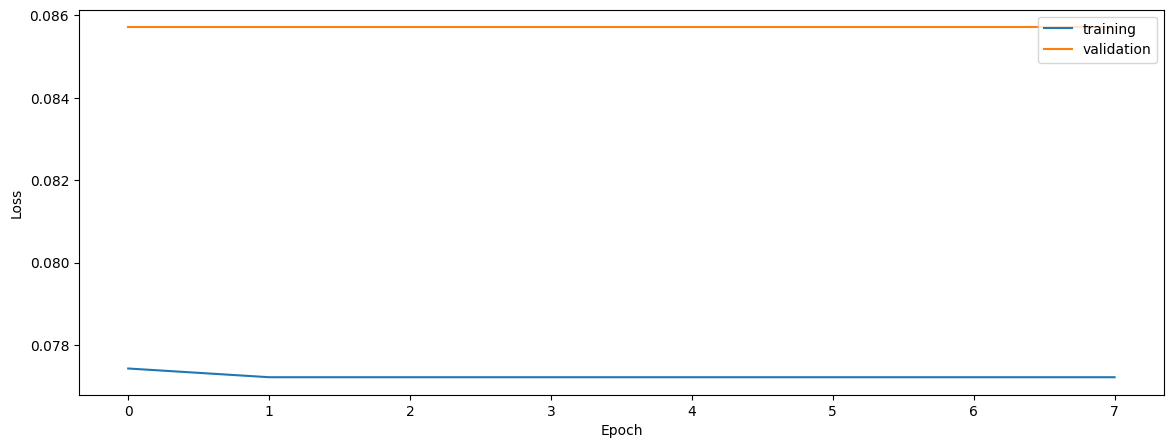

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
-0.15870703764305283
-0.21354685802342174
-0.1674099428015043


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
-0.15870703764305283
-0.21354685802342174
-0.1674099428015043


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
-0.17300931218423998
-0.21404183471659388
-0.1827942038377411


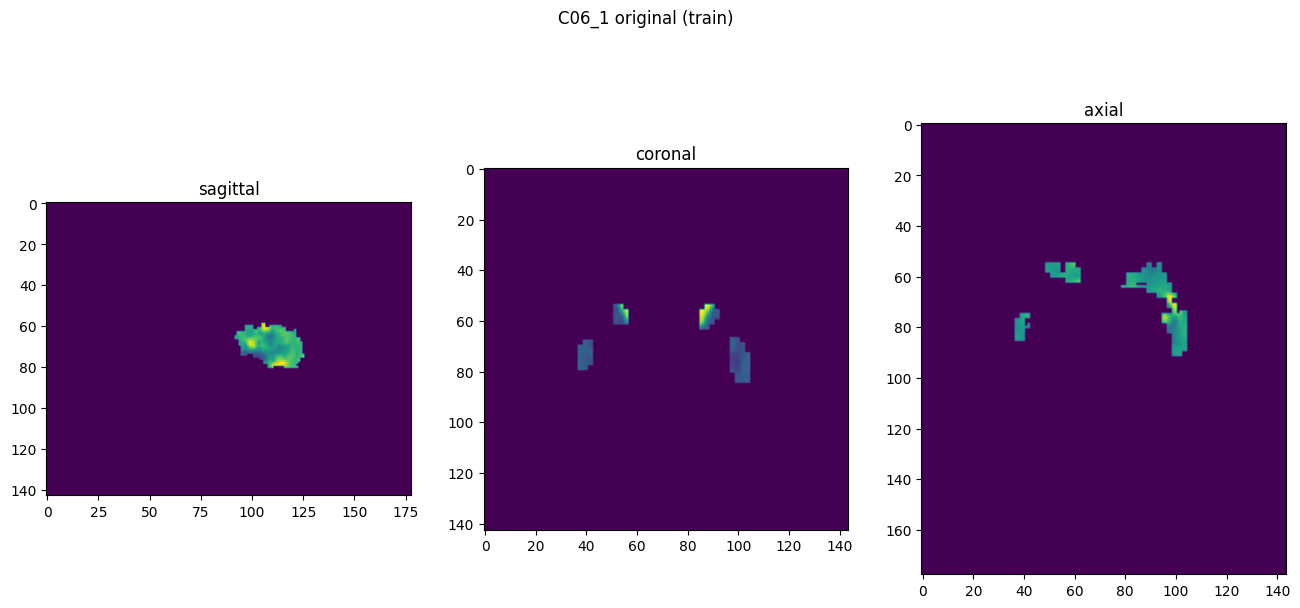

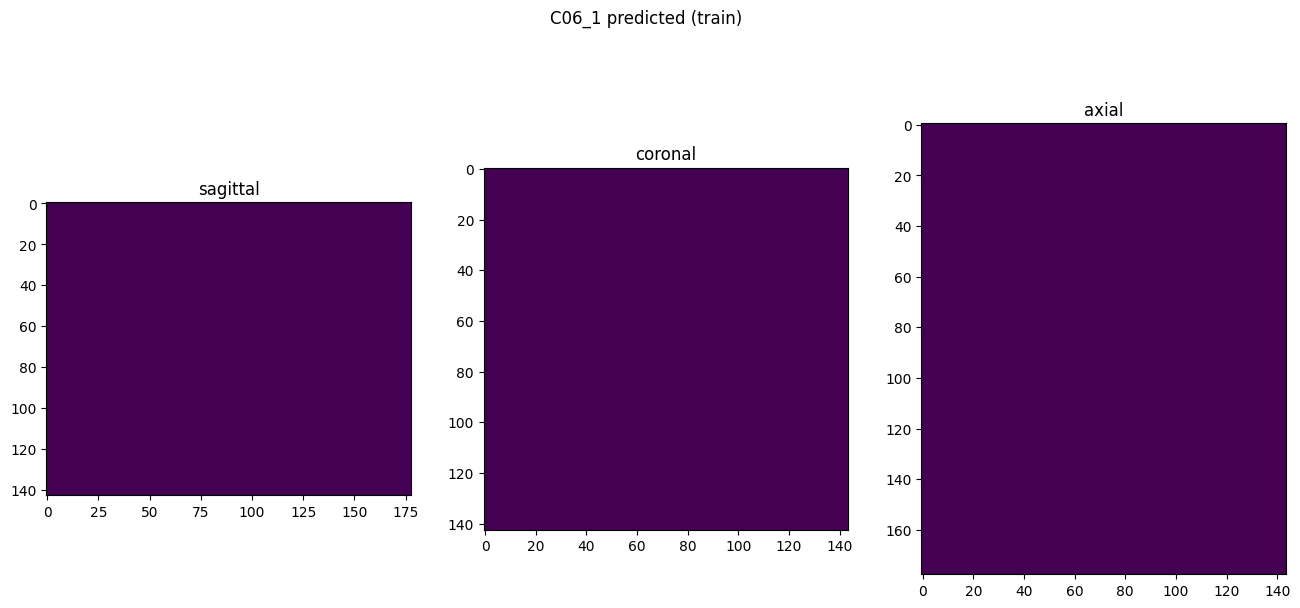

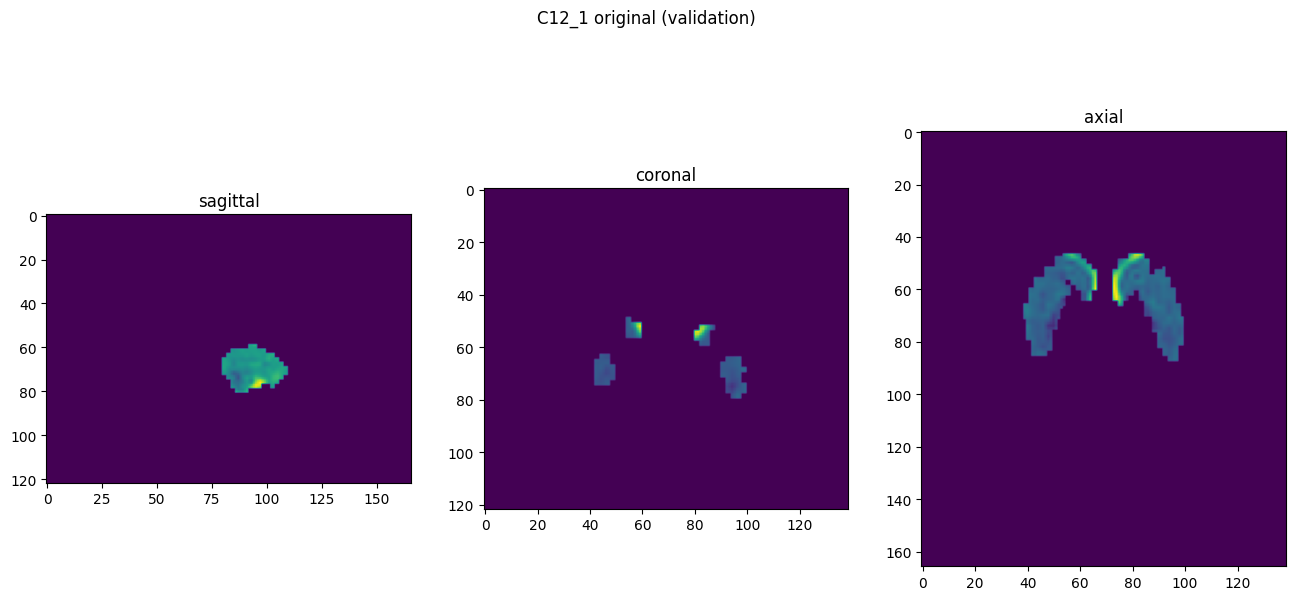

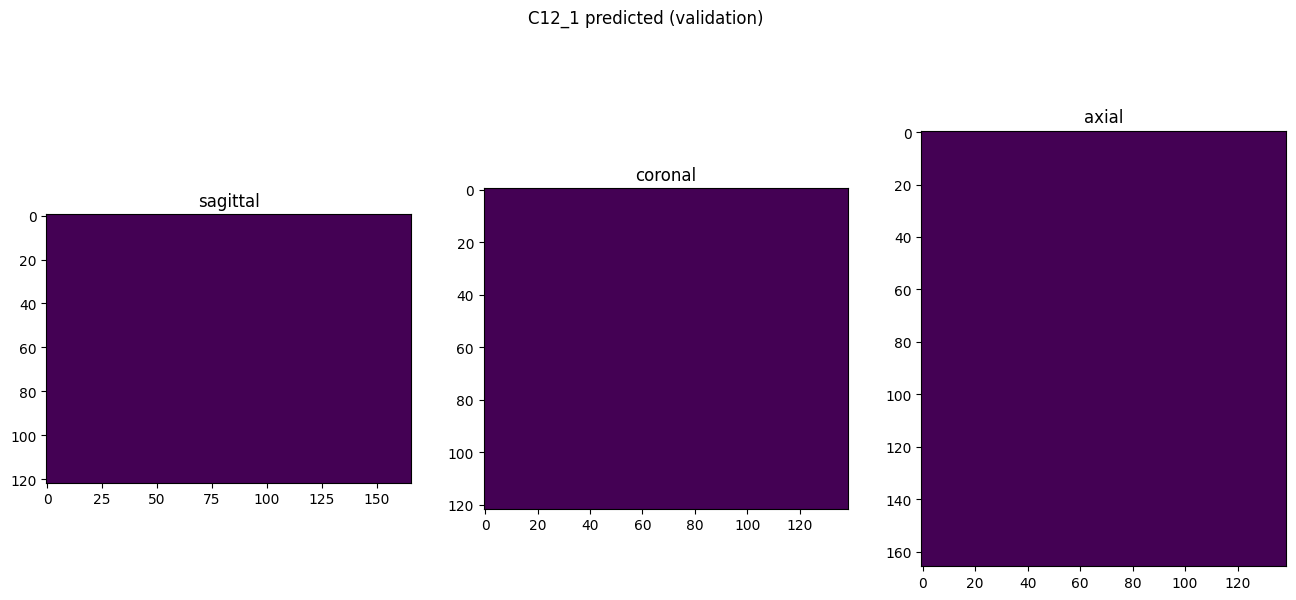

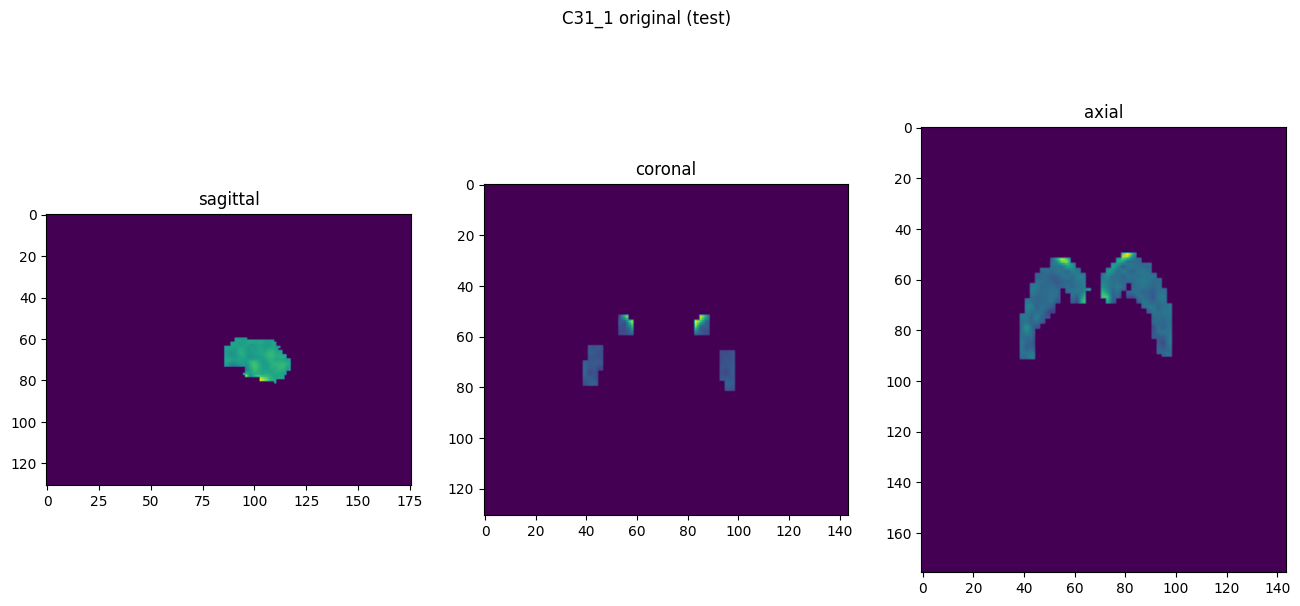

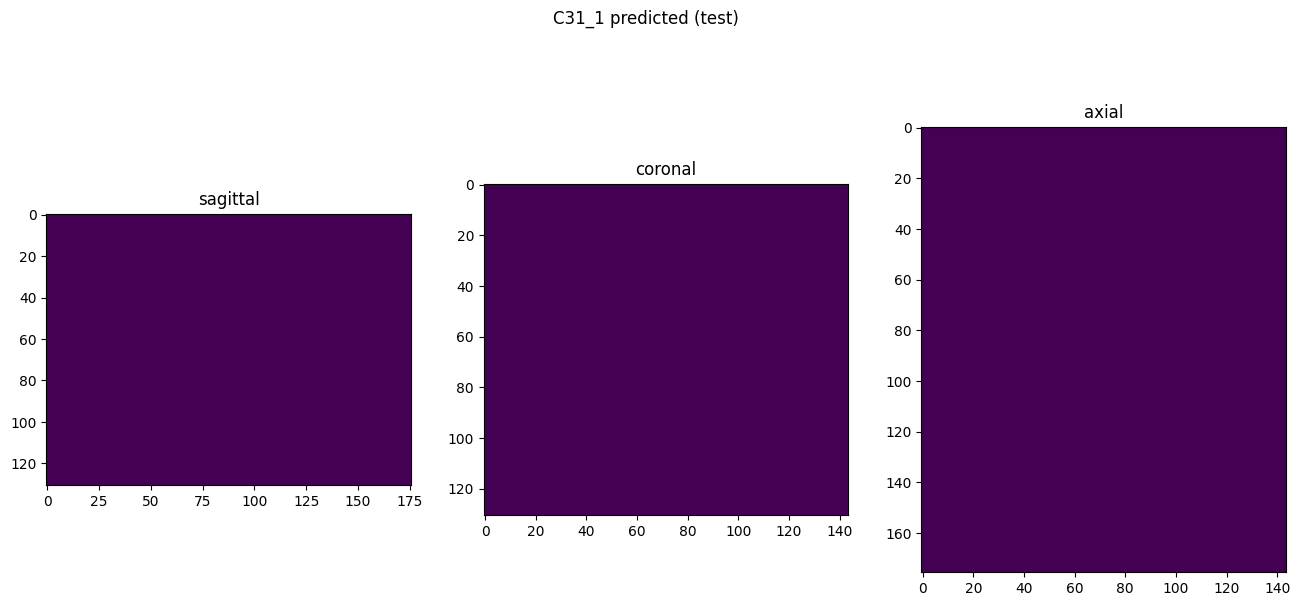

In [10]:
showResults(model, gen, threshold=None, background=False)